In [1]:
%matplotlib inline


==========================================================
Load CT slices and plot axial, sagittal and coronal images
==========================================================

This example illustrates loading multiple files, sorting them by slice
location, building a 3D image and reslicing it in different planes.

.. usage:

   reslice.py <glob>
   where <glob> refers to a set of DICOM image files.

   Example: python reslice.py "*.dcm". The quotes are needed to protect
   the glob from your system and leave it for the script.

.. note:

   Uses numpy and matplotlib.


In [2]:
# import os
# PathDicom = "/data/Pat1/CT_scan/DICOM/PA000001/ST000001/SE000005"
# lstFilesDCM = []  # create an empty list
# count = 0
# for dirName, subdirList, fileList in os.walk(PathDicom):
#     for filename in fileList:
#         print(filename)
#         count+=1

785


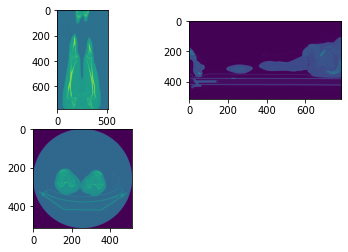

In [3]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob

# load the DICOM files
import os
PathDicom = "/data/Pat1/CT_scan/DICOM/PA000001/ST000001/SE000005"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".zip" not in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))
# print(len(lstFilesDCM))
files = []
# print('glob: {}'.format(sys.argv[1]))
for fname in lstFilesDCM:
#     print("loading: {}".format(fname))
    files.append(pydicom.dcmread(fname))

# print("file count: {}".format(len(files)))

# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

# print("skipped, no SliceLocation: {}".format(skipcount))

# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)
print(len(slices))

# pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

# plot 3 orthogonal slices
a1 = plt.subplot(2, 2, 3)
plt.imshow(img3d[:, :, img_shape[2]//2])
a1.set_aspect(ax_aspect)

a2 = plt.subplot(2, 2, 2)
plt.imshow(img3d[:, img_shape[1]//2, :])
a2.set_aspect(sag_aspect)

a3 = plt.subplot(2, 2, 1)
plt.imshow(img3d[img_shape[0]//2, :, :].T)
a3.set_aspect(cor_aspect)

plt.show()

In [4]:
print(slices[0].ImagePositionPatient)
print(slices[0].PixelSpacing)
print(slices[0].SliceThickness)

[-250.0, -250.0, -125.0]
[0.976562, 0.976562]
1.25


In [5]:
# np.average(img3d.ravel())

In [6]:
import copy
# # plot 3 orthogonal slices
# a1 = plt.subplot(2, 2, 1)
# my_array = copy.deepcopy(img3d[:, :, img_shape[2]//2])
# my_array[my_array <= 1500] = 0
# plt.imshow(my_array)

# a1.set_aspect(ax_aspect)
# a2 = plt.subplot(2, 2, 2)
# my_array = copy.deepcopy(img3d[:, :, img_shape[2]//2])
# my_array[my_array <= 2000] = 0
# plt.imshow(my_array)

# a2.set_aspect(ax_aspect)


In [7]:
# a3 = plt.subplot(2, 2, 1)
# my_array = copy.deepcopy(img3d[img_shape[0]//2, :, :].T)
# a3.set_aspect(cor_aspect)
# my_array[my_array <= 1500] = 0
# plt.imshow(my_array)
# a3.set_aspect(ax_aspect)

# a2 = plt.subplot(2, 2, 2)
# my_array = copy.deepcopy(img3d[img_shape[0]//2, :, :].T)
# a3.set_aspect(cor_aspect)
# my_array[my_array <= 2000] = 0
# plt.imshow(my_array)
# a2.set_aspect(ax_aspect)


In [8]:
array_3d = copy.deepcopy(img3d)
array_3d[array_3d <= 1500] = 0


In [9]:
# x, y, z = [], [], []

# for i, img2d in enumerate(img3d):
#     for j, img1d in enumerate(img2d):
#         for k, pixal in enumerate(img1d):
#             if pixal > 1500:
#                 x.append(int(i))
#                 y.append(int(j))
#                 z.append(int(k))

# x = np.array(x)
# y = np.array(y)
# z = np.array(z)

In [10]:
# import ipyvolume as ipv
# ipv.figure()
# ipv.scatter(x, y, z, marker='sphere')

# ipv.save('bone.html')



In [ ]:
import scipy.ndimage
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = list(scan[0].PixelSpacing)
    spacing = np.array(spacing)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print ("Shape before resampling\t", array_3d.shape)
imgs_after_resamp, spacing = resample(array_3d, slices, [1,1,1])
print ("Shape after resampling\t", imgs_after_resamp.shape)

In [32]:
print ("Shape before resampling\t", array_3d.shape)
print ("Shape after resampling\t", imgs_after_resamp.shape)

Shape before resampling	 (512, 512, 785)
Shape after resampling	 (500, 500, 981)


In [30]:
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


def plot_3d(p, label=None):

    # Position the scan upright, 
    # so the head of the patient would be at the top facing the   
    # camera
    # p = image.transpose(2,1,0)
    # p = image.transpose(1,0,2)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    # Fancy indexing: `verts[faces]` to generate a collection of    
    # triangles
    if label is not None:
        verts, faces, _, _ = measure.marching_cubes_lewiner(label)
        mesh = Poly3DCollection(verts[faces], alpha=0.20)
        face_color = 'red'
        mesh.set_facecolor(face_color)
        ax.add_collection3d(mesh)

    verts, faces, _, _ = measure.marching_cubes_lewiner(p)
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.show()

In [12]:
# plot_3d(array_3d)

In [26]:
def convert_global_aix_to_net_pos(point, spacing, origin):
    point['x'] = (point['x'] - origin[0]) / spacing[0]
    point['y'] = (point['y'] - origin[1]) / spacing[1]
    point['z'] = (point['z'] - origin[2]) / spacing[2]
    return point

In [27]:
path_csv = '/data/Pat1/POD_JR_9060K_Landmarks_femur.csv'
import pandas as pd
data = pd.read_csv(path_csv, names=["Name", "x", "y", "z"])
data = convert_global_aix_to_net_pos(data, spacing, slices[0].ImagePositionPatient)
data

,Name,x,y,z
0,PCLOrigin,176.793391,274.939841,494.768012
1,femoralCenter,163.265884,253.149630,471.782870
2,greaterTrochanter,103.227753,261.263534,887.354665
3,hipCenter,154.847479,234.719220,884.749929
4,lateralCondyle,140.977972,263.863635,464.298177
5,lateralEpicondyle,121.690362,270.546739,489.334297
6,lateralPosteriorCondyle,141.063672,293.374250,485.902872
7,medialCondyle,193.109199,263.664735,464.269585
8,medialEpicondyle,208.638599,256.533867,491.712033
9,medialPosteriorCondyle,193.780799,291.472649,489.158142


In [23]:
# print(list(slices[0].PixelSpacing))
# # Determine current pixel spacing
# spacing = map(float, ([slices[0].SliceThickness] + list(slices[0].PixelSpacing)))
# spacing = np.array(list(spacing))
# print(spacing)

In [28]:
mark_img = np.zeros(imgs_after_resamp.shape)
# x = np.zeros(img_shape)

cude_size = 3
for i in range(-cude_size, cude_size):
    for j in range(-cude_size, cude_size):
        for k in range(-cude_size, cude_size):
            for index, row in data.iterrows():
                mark_img[i+int(row['x']), j+int(row['y']), k+int(row['z'])] = 5200

# plot_3d(imgs_after_resamp, mark_img)

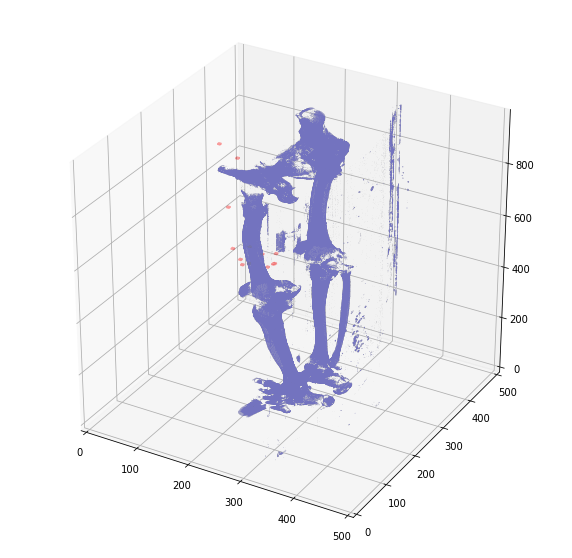

In [29]:
plot_3d(imgs_after_resamp, mark_img)

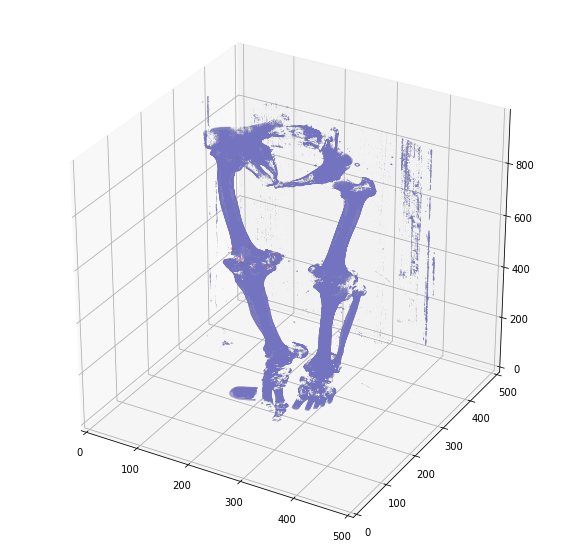

In [31]:
plot_3d(imgs_after_resamp.transpose(1,0,2), mark_img)

In [ ]:
# x = np.linspace(0, 512, 100)
# y = np.sin(x)*x
# print(len(x),max(y))

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv3D, MaxPooling3D
from keras.optimizers import SGD
import os
from keras import backend as K

Using TensorFlow backend.


In [2]:

batch_size = 5
num_classes = 10
epochs = 20
learning_rate = 0.01

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
colors = x_train.shape[3]


if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1,colors, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1,colors, img_rows, img_cols)
    input_shape = (1, colors, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, colors, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, colors, 1)
    input_shape = (img_rows, img_cols, colors, 1)


# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


170500096/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 1), activation='relu', input_shape=input_shape))
model.add(Conv3D(32, kernel_size=(3, 3, 1), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 1)))

model.add(Dropout(0.25))
model.add(Conv3D(64, kernel_size=(3, 3, 1), activation='relu'))
model.add(Conv3D(64, kernel_size=(3, 3, 1), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 1)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

sgd=SGD(lr=learning_rate)


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=sgd,
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])